### Поиск выбросов и генерация новых признаков

#### Обучение без обработки выбросов

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.font_manager 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('glass.csv')
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Пропусков в данных нет.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [4]:
statistic = [['model', 'Score_Test', 'Score_Train']]

def train(df, model, model_name):
  X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[:-1]],
                                                    df[df.columns[-1]], test_size=0.2, random_state=2)
  model.fit(X_train, Y_train)    

  Score_Test = model.score(X_test, Y_test)
  Score_Train = model.score(X_train, Y_train)

  print("Test Score: ", Score_Test)
  print("Train Score: ", Score_Train)
  statistic.append([model_name, Score_Test, Score_Train])

Обучим модель RandomForestClassifier. Модель явно переобучилась, но выдает неплохие результаты на тесте.

In [5]:
random_forest_model = RandomForestClassifier(random_state=2)
train(df, random_forest_model, 'RandomForestClassifier')

Test Score:  0.813953488372093
Train Score:  1.0


#### Обработка выбросов в данных

Построим график boxplot можем заметить явные выбросы у признаков Ca, Ba.

<AxesSubplot:>

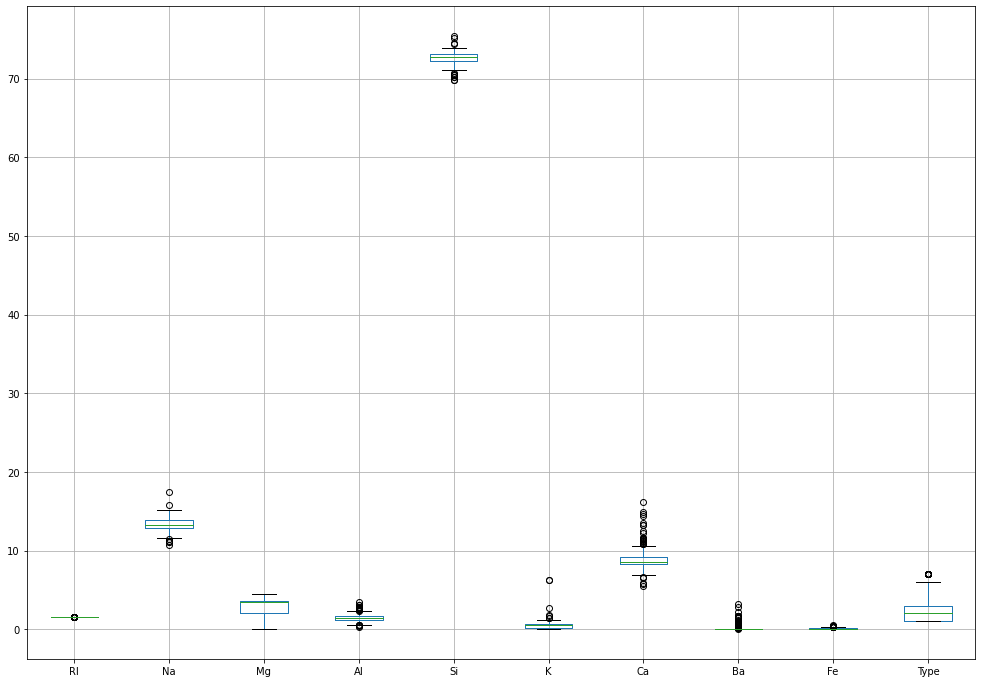

In [6]:
plt.figure(figsize=(17, 12)) 
df.boxplot()

Посмотрим на распределения признаков

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

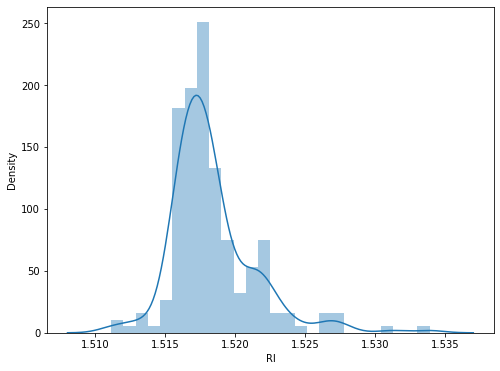

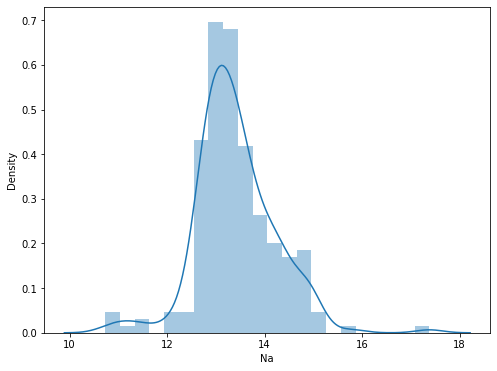

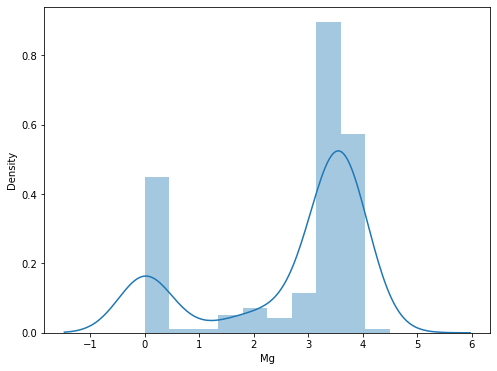

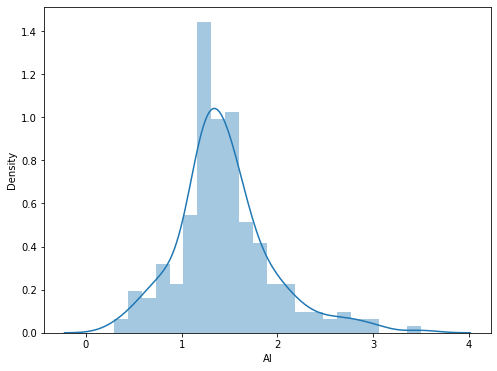

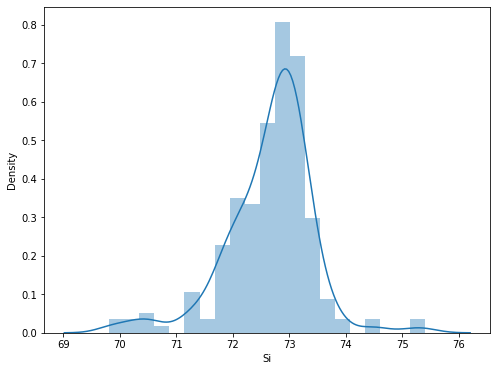

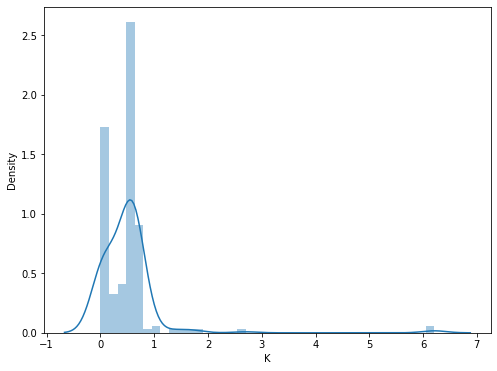

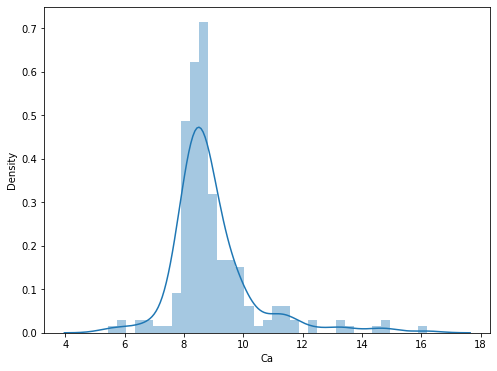

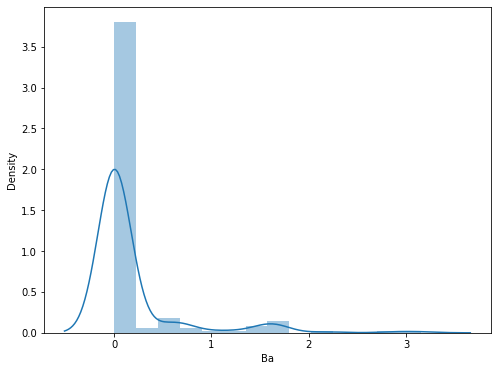

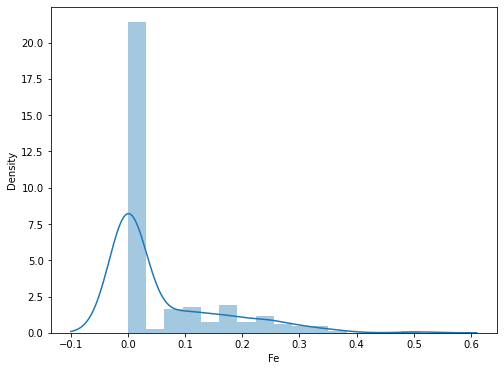

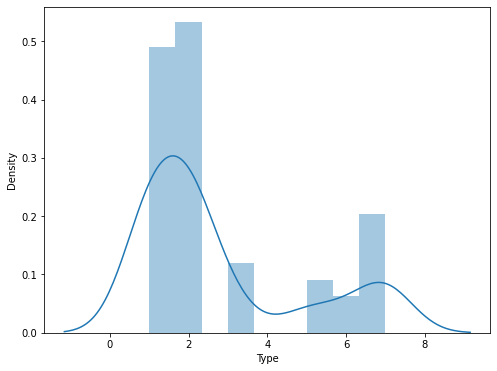

In [7]:
for column in df.columns:
    plt.figure(figsize=(8, 6))             
    sns.distplot(df[column])

Те же графики через pandas. Нормальное распределение со скосом можно видеть у признаков Ri, Na, Al, Si, Ca.

array([[<AxesSubplot:title={'center':'RI'}>,
        <AxesSubplot:title={'center':'Na'}>,
        <AxesSubplot:title={'center':'Mg'}>],
       [<AxesSubplot:title={'center':'Al'}>,
        <AxesSubplot:title={'center':'Si'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'Ca'}>,
        <AxesSubplot:title={'center':'Ba'}>,
        <AxesSubplot:title={'center':'Fe'}>],
       [<AxesSubplot:title={'center':'Type'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

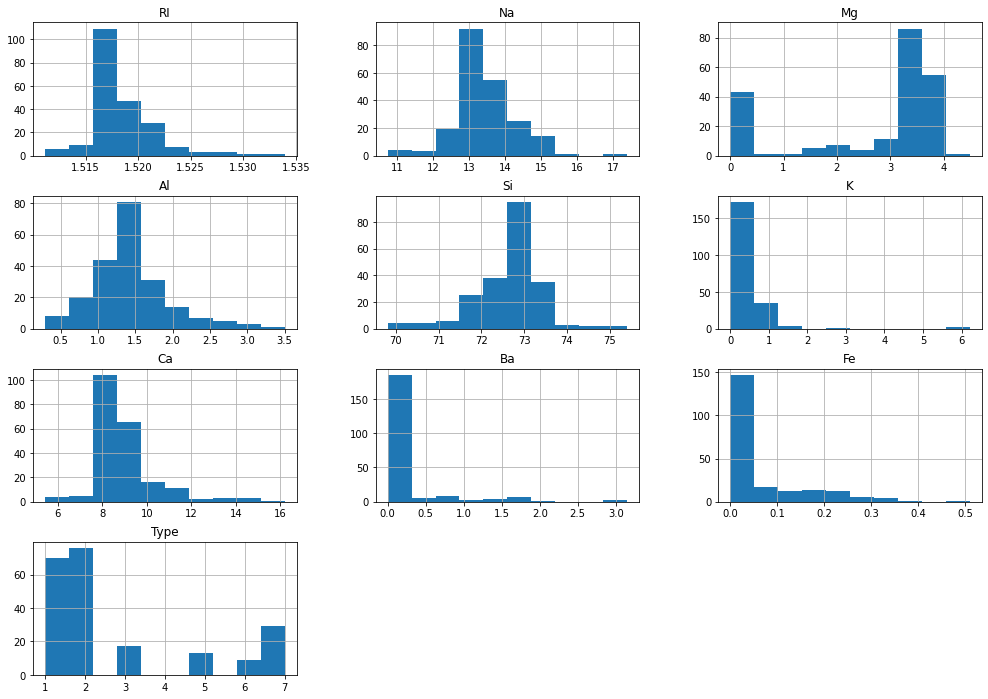

In [8]:
df.hist(figsize=(17, 12))

Нормализуем наш Датафрейм

In [9]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [10]:
normalized_df = pd.DataFrame(data=np.c_[preprocessing.normalize(df.iloc[:, :-1]), df.iloc[:,-1]], columns=df.columns)
normalized_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.020625,0.184956,0.060884,0.014916,0.973323,0.000814,0.118648,0.000000,0.0,1.0
1,0.020350,0.186259,0.048274,0.018237,0.975277,0.006437,0.104997,0.000000,0.0,1.0
2,0.020282,0.180987,0.047487,0.020600,0.976368,0.005217,0.104071,0.000000,0.0,1.0
3,0.020404,0.177605,0.049611,0.017344,0.976220,0.007663,0.110515,0.000000,0.0,1.0
4,0.020279,0.177341,0.048378,0.016571,0.976647,0.007350,0.107848,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
209,0.020319,0.189493,0.000000,0.038596,0.973063,0.001072,0.123023,0.014205,0.0,7.0
210,0.020198,0.198674,0.000000,0.026499,0.972861,0.000000,0.111854,0.021172,0.0,7.0
211,0.020182,0.190587,0.000000,0.026810,0.974438,0.000000,0.112017,0.021766,0.0,7.0
212,0.020077,0.190373,0.000000,0.025683,0.974505,0.000000,0.112265,0.020785,0.0,7.0


#### OneClassSVM

Реализуем метод опорных векторов (one class SVM) для поиска выбросов.

Выделяем 2 главных компонента в данных с помощью PCA. Зададим значение OUTLIER_FRACTION = 0.05, это нам говорит что мы ищем 5% выбросов в данных.

In [11]:
X = PCA(n_components=2).fit_transform(normalized_df.iloc[:,:-1])
normalized_df_num = X.shape[0]
OUTLIER_FRACTION = 0.05

In [12]:
clf = OneClassSVM(kernel="rbf")
clf.fit(X)

OneClassSVM()

In [13]:
dist_to_border = clf.decision_function(X).ravel()
threshold = stats.scoreatpercentile(dist_to_border,
            100 * OUTLIER_FRACTION)
is_inlier = dist_to_border > threshold

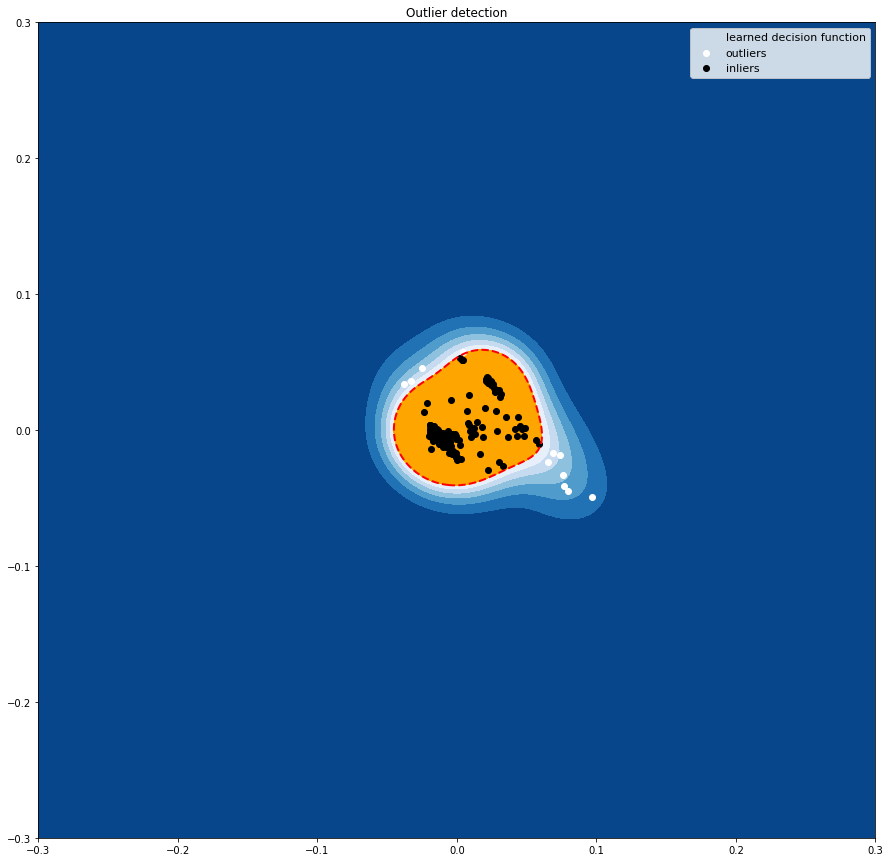

In [14]:
plt.figure(figsize=(15, 15))
xx, yy = np.meshgrid(np.linspace(-0.3, 0.3, 500), np.linspace(-0.3, 0.3, 500))
n_inliers = int((1. - OUTLIER_FRACTION) * normalized_df_num)
n_outliers = int(OUTLIER_FRACTION * normalized_df_num)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(X[is_inlier == 0, 0], X[is_inlier == 0, 1], c='white')
c = plt.scatter(X[is_inlier == 1, 0], X[is_inlier == 1, 1], c='black')
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlim((-0.3, 0.3))
plt.ylim((-0.3, 0.3))
plt.show()

На графике мы видим выделенную область и черные точки - это валидная зона и валидные точки. Белые точки наша модель считает выбросами. Посмотрим на них. Ниже представлен датафрейм выбросов.

In [15]:
normalized_df[~is_inlier]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
105,0.020514,0.154050,0.000000,0.025294,0.971255,0.010898,0.178133,0.000000,0.004574,2.0
106,0.021270,0.149049,0.000000,0.029171,0.969719,0.008057,0.184748,0.043756,0.003889,2.0
107,0.020993,0.168331,0.000000,0.013685,0.960172,0.001642,0.221568,0.000000,0.003285,2.0
110,0.020213,0.148690,0.000000,0.010195,0.969329,0.000000,0.194369,0.000000,0.000000,2.0
111,0.020251,0.146107,0.000000,0.009944,0.968919,0.000000,0.198345,0.000000,0.000000,2.0
112,0.020495,0.169564,0.000000,0.008988,0.966142,0.000805,0.193175,0.000000,0.000000,2.0
131,0.020677,0.185616,0.000000,0.018426,0.965201,0.002574,0.182093,0.000000,0.001355,2.0
163,0.021124,0.195324,0.037364,0.048796,0.974391,0.023422,0.081838,0.030672,0.000000,5.0
185,0.020308,0.183953,0.042999,0.024321,0.978351,0.023649,0.072963,0.015990,0.000000,7.0
186,0.020783,0.196003,0.044621,0.030386,0.975223,0.019984,0.079250,0.022310,0.000000,7.0


Избавимся от выбросов

In [16]:
df_after_deletion_outliers = normalized_df[is_inlier].reset_index()
df_after_deletion_outliers

,index,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,0.020625,0.184956,0.060884,0.014916,0.973323,0.000814,0.118648,0.000000,0.0,1.0
1,1,0.020350,0.186259,0.048274,0.018237,0.975277,0.006437,0.104997,0.000000,0.0,1.0
2,2,0.020282,0.180987,0.047487,0.020600,0.976368,0.005217,0.104071,0.000000,0.0,1.0
3,3,0.020404,0.177605,0.049611,0.017344,0.976220,0.007663,0.110515,0.000000,0.0,1.0
4,4,0.020279,0.177341,0.048378,0.016571,0.976647,0.007350,0.107848,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
198,209,0.020319,0.189493,0.000000,0.038596,0.973063,0.001072,0.123023,0.014205,0.0,7.0
199,210,0.020198,0.198674,0.000000,0.026499,0.972861,0.000000,0.111854,0.021172,0.0,7.0
200,211,0.020182,0.190587,0.000000,0.026810,0.974438,0.000000,0.112017,0.021766,0.0,7.0
201,212,0.020077,0.190373,0.000000,0.025683,0.974505,0.000000,0.112265,0.020785,0.0,7.0


#### IsolationForest

Посмотрим на модель IsolationForest для определения выбросов.

In [17]:
def scat_plot(X, Y, X_outliers, Y_outliers):
  plt.scatter(X, Y)
  plt.scatter(X_outliers, Y_outliers)
  plt.title("График выбросов")
  plt.show()

Обучим модель на наших данных. Зададим параметр contamination (процент выбросов в данных) равным 0.03.

In [18]:
isolation_forest = IsolationForest(contamination = 0.03)
prediction = isolation_forest.fit_predict(df_after_deletion_outliers.iloc[:,:-1])
prediction[:20]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Количество выбросов в данных после прогона модели.

In [19]:
len(prediction[prediction < 0])

7

Построим графики и взглянем какие точки определились как выбросы.

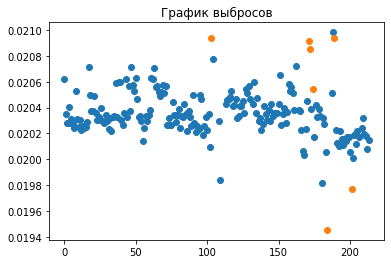

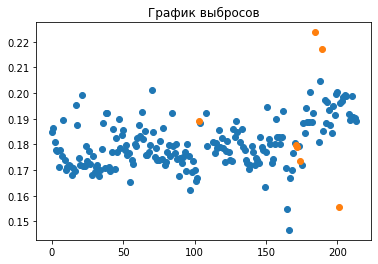

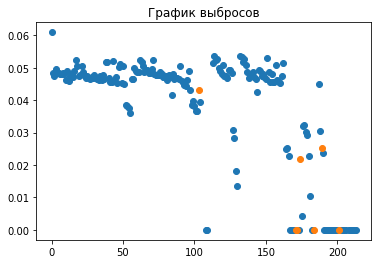

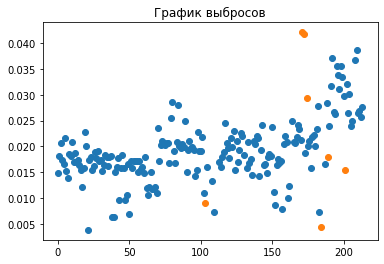

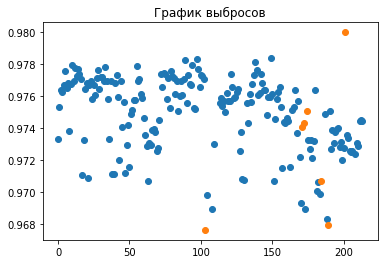

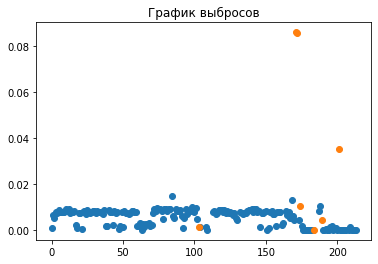

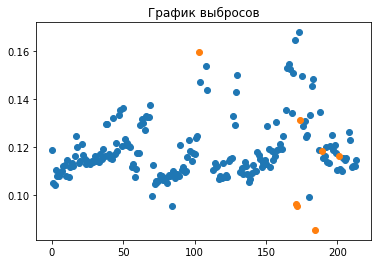

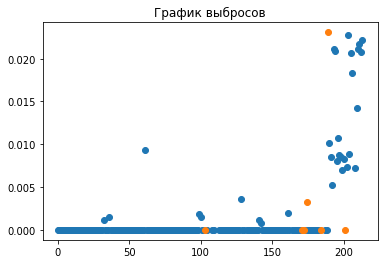

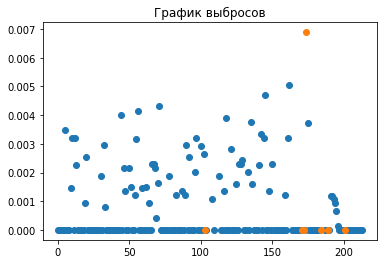

In [20]:
normal_data = df_after_deletion_outliers.iloc[:,:-1].loc[np.where(prediction > 0)]
outliers = df_after_deletion_outliers.iloc[:,:-1].loc[np.where(prediction < 0)]
for i in range(1, normal_data.shape[1]):
  scat_plot(normal_data.iloc[:, 0], normal_data.iloc[:, i], outliers.iloc[:, 0], outliers.iloc[:, i])


Датафрейм выбросов

In [21]:
df_after_deletion_outliers.loc[np.where(prediction < 0)]

,index,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
103,103,0.020941,0.189223,0.043192,0.009050,0.967643,0.001097,0.159606,0.000000,0.00000,2.0
163,171,0.020913,0.179942,0.000000,0.042014,0.974064,0.085825,0.096190,0.000000,0.00000,5.0
164,172,0.020854,0.179153,0.000000,0.041619,0.974316,0.085580,0.095502,0.000000,0.00000,5.0
166,174,0.020541,0.173590,0.021749,0.029314,0.975078,0.010267,0.131037,0.003242,0.00689,5.0
176,184,0.019452,0.223717,0.000000,0.004377,0.970683,0.000000,0.085599,0.000000,0.00000,6.0
179,189,0.020941,0.217012,0.025151,0.018004,0.967965,0.004261,0.118333,0.023089,0.00000,7.0
191,201,0.019768,0.155766,0.000000,0.015511,0.979958,0.035194,0.116401,0.000000,0.00000,7.0


Избавимся от выбросов

In [22]:
df_after_deletion_outliers_v2 = df_after_deletion_outliers.loc[np.where(prediction > 0)].reset_index()
df_after_deletion_outliers_v2

,level_0,index,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,0,0.020625,0.184956,0.060884,0.014916,0.973323,0.000814,0.118648,0.000000,0.0,1.0
1,1,1,0.020350,0.186259,0.048274,0.018237,0.975277,0.006437,0.104997,0.000000,0.0,1.0
2,2,2,0.020282,0.180987,0.047487,0.020600,0.976368,0.005217,0.104071,0.000000,0.0,1.0
3,3,3,0.020404,0.177605,0.049611,0.017344,0.976220,0.007663,0.110515,0.000000,0.0,1.0
4,4,4,0.020279,0.177341,0.048378,0.016571,0.976647,0.007350,0.107848,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
191,198,209,0.020319,0.189493,0.000000,0.038596,0.973063,0.001072,0.123023,0.014205,0.0,7.0
192,199,210,0.020198,0.198674,0.000000,0.026499,0.972861,0.000000,0.111854,0.021172,0.0,7.0
193,200,211,0.020182,0.190587,0.000000,0.026810,0.974438,0.000000,0.112017,0.021766,0.0,7.0
194,201,212,0.020077,0.190373,0.000000,0.025683,0.974505,0.000000,0.112265,0.020785,0.0,7.0


In [23]:
random_forest_model_after_deletion_outliers = RandomForestClassifier(random_state=2)
train(df_after_deletion_outliers, random_forest_model_after_deletion_outliers, 'RandomForestClassifier after deletion outliers')

Test Score:  0.975609756097561
Train Score:  1.0


In [24]:
random_forest_model_after_deletion_outliers_v2 = RandomForestClassifier(random_state=2)
train(df_after_deletion_outliers_v2, random_forest_model_after_deletion_outliers_v2, 'RandomForestClassifier after deletion outliers v2')

Test Score:  1.0
Train Score:  1.0


In [25]:
stat = pd.DataFrame(statistic[1:], columns = statistic[0])
stat

,model,Score_Test,Score_Train
0,RandomForestClassifier,0.813953,1.0
1,RandomForestClassifier after deletion outliers,0.975610,1.0
2,RandomForestClassifier after deletion outliers v2,1.000000,1.0


### Вывод

В этой работе я научился находить выбросы с помощью диаграмм и моделей. Работать с некоторыми гиперпараметрами с целью контроля поиска выбрасов в данных. Потому что иногда без этого можно удалить нужные данные посчитав их за выбросы. 

По оценке точности на тестовом наборе данных видно, что изначально модель давала 0.81% правильных ответов, после применения OneClassSVM и чистки данных получили метрику равную 0.97%, после применения IsolationForest метрика улучшилась до 1, что означает что модель выдает всегда правильные ответы на тестовом множестве. На других данных метрики могут отличаться.

Данные на выбросы однозначно надо исследовать так как это повышает метрики моделей, что является одной из наших основных целей.

Наверное главный минус это шанс удалить валидные данные. 



### Вопросы

1) 100% на тесте это нормальное поведение? Или это нам о чем-то сигнализирует? (маленькая выборка и тп). 